In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Add the swish function to Keras
import tensorflow as tf
from tensorflow.keras.activations import softplus, tanh, sigmoid, softplus, elu, selu, relu, softsign, hard_sigmoid
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sin
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import ThresholdedReLU

#leaky relu
def lrelu(x):
    return 0.01*x
get_custom_objects().update({'lrelu':Activation(lrelu)})

#parametric relu
#learnable param
alfa=tf.Variable(0.25)
def prelu(x):
    return alfa*x
get_custom_objects().update({'prelu':Activation(prelu)})

# Add the GELU function to Keras
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

#beta=1
def swish_1(x):
    return x*tf.math.sigmoid(x)
get_custom_objects().update({'swish_1':Activation(swish_1)})

#learnable param
beta=tf.Variable(0.1)
def swish(x):
    return x*tf.math.sigmoid(beta*x)
get_custom_objects().update({'swish':Activation(swish)})

from tensorflow.keras.activations import sigmoid, relu, tanh, softplus, selu, elu, softsign
def SoftClipping_Swish(x):
    return tf.maximum(0.0, swish(x))
get_custom_objects().update({'SoftClipping Swish':Activation(SoftClipping_Swish)})

alpha = tf.Variable(0.25)
def SoftClipping_Mish_learnable(x):
    return tf.maximum(0.0,x*tanh(softplus(alpha*x)))
get_custom_objects().update({'SoftClipping_Mish_learnable':Activation(SoftClipping_Mish_learnable)})

def mish(x):
    return x*tanh(softplus(x))
get_custom_objects().update({'mish':Activation(mish)})

def swish(x):
    return x*sigmoid(x)
get_custom_objects().update({'Swish':Activation(swish)})

get_custom_objects().update({'ReLU':Activation(relu)})
get_custom_objects().update({'Sigmoid':Activation(sigmoid)})

# act_func = ['HeLU','mish','relu','swish']
act_func = ['Sigmoid','ReLU','Swish', 'SoftClipping Swish']

In [4]:
import pandas as pd

filepath_dict = {'yelp':   '/content/drive/MyDrive/Dis/data/yelp_labelled.txt',
                 'amazon': '/content/drive/MyDrive/Dis/data/amazon_cells_labelled.txt',
                 'imdb':   '/content/drive/MyDrive/Dis/data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[1])
print(df.iloc[2])
print(df.iloc[0])
print(df.iloc[3])
print(df.iloc[4])

sentence    Crust is not good.
label                        0
source                    yelp
Name: 1, dtype: object
sentence    Not tasty and the texture was just nasty.
label                                               0
source                                           yelp
Name: 2, dtype: object
sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object
sentence    Stopped by during the late May bank holiday of...
label                                                       1
source                                                   yelp
Name: 3, dtype: object
sentence    The selection on the menu was great and so wer...
label                                                       1
source                                                   yelp
Name: 4, dtype: object


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
sentences = ['Eric dislikes mornings.', 'Eric likes evenings.']
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'Eric': 0, 'dislikes': 1, 'evenings': 2, 'likes': 3, 'mornings': 4}

In [6]:
vectorizer.transform(sentences).toarray()

array([[1, 1, 0, 0, 1],
       [1, 0, 1, 1, 0]])

In [7]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=123)

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

Overall I was not impressed and would not go back.
[188, 3, 4, 12, 189, 2, 50, 12, 39, 29]


In [9]:
for word in ['the', 'all', 'is', 'hate', 'happy', 'sad']:
  print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 37
is: 7
hate: 629
happy: 291
sad: 299


In [10]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 75 297   1  49 754  19  28  47  22   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [11]:
def create_model(act):
  embedding_dim = 50

  model = Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            input_length=maxlen))
  model.add(layers.GlobalMaxPool1D())
  model.add(layers.Dense(10, activation=act))
  model.add(layers.Dense(10, activation=act))
  model.add(layers.Dense(1, activation='sigmoid'))
    
  callbacks = [
      keras.callbacks.ModelCheckpoint("sentiment_dense.keras",
                                      save_best_only=True)
  ] 
  model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
  return model

In [13]:
from tensorflow import keras 
from tensorflow.keras import layers

result = [] 
for act in act_func[:]:
  print('\nTraining with -->{0}<-- activation function\n'.format(act))
  model = create_model(act=act)
  model.summary()

  history = model.fit(X_train, y_train,
                      epochs=100,
                      verbose=False,
                      validation_data=(X_test, y_test),
                      batch_size=10)
  
  loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
  print('\nTraining with -->{0}<-- activation function\n'.format(act))
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy :  {:.4f}".format(accuracy))

  result.append(history)
    
  K.clear_session()
  del model


Training with -->Sigmoid<-- activation function

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           90350     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 90,981
Trainable params: 90,981
Non-trainable params: 0
__

In [14]:
new_act_arr = act_func[:]
new_results = result[:]

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,8))
#     plt.style.use('ggplot')
    
    # Plot validation accuracy values
    for act_func in results:
        plt.plot(act_func.history['val_accuracy'])
        
#     plt.title('Model accuracy')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

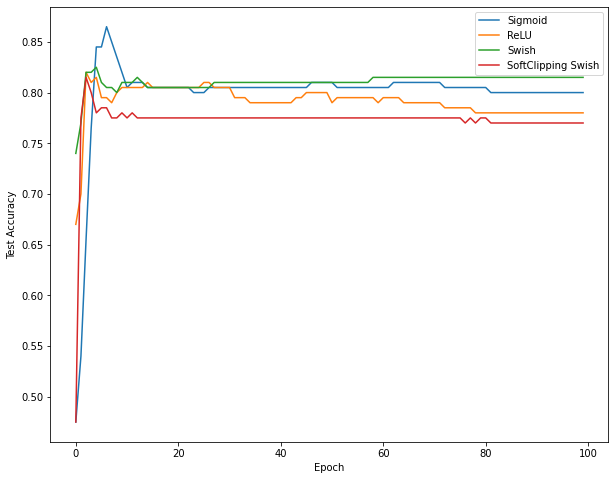

In [15]:
plot_act_func_results(new_results, new_act_arr)

In [16]:
new_act_arr = act_func[:]
new_results = result[:]

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,8))
#     plt.style.use('ggplot')
    
    # Plot validation accuracy values
    for act_func in results:
        plt.plot(act_func.history['val_loss'])
        
#     plt.title('Model accuracy')
    plt.ylabel('Test Loss')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

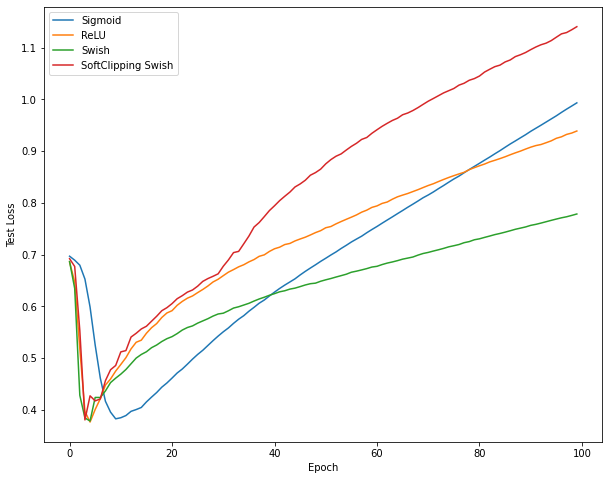

In [17]:
plot_act_func_results(new_results, new_act_arr)